# California vs. Portugal Climate Analysis

This notebook explores long-term climate patterns for four cities:

- Los Angeles, USA  
- San Francisco, USA  
- Lisbon, Portugal  
- Porto, Portugal  

Data source: [Open-Meteo Historical Weather API](https://open-meteo.com/)  
Pipeline: Python ingestion → DuckDB Bronze → dbt Silver (daily + monthly).

In [2]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Show plots inline
%matplotlib inline

# Connect to your existing DuckDB file
con = duckdb.connect("../data/warehouse/climate.duckdb")

In [3]:
def q(sql: str) -> pd.DataFrame:
    """Run a SQL query against DuckDB and return a pandas DataFrame."""
    return con.execute(sql).df()

In [4]:
q("SELECT COUNT(*) FROM bronze_daily_weather")

,count_star()
0,65748


In [5]:
q("""
SELECT
    (SELECT COUNT(*) FROM bronze_daily_weather)  AS n_bronze,
    (SELECT COUNT(*) FROM silver_daily_weather_features) AS n_daily,
    (SELECT COUNT(*) FROM silver_monthly_climate) AS n_monthly
""")

,n_bronze,n_daily,n_monthly
0,65748,65748,2160


In [6]:
q("""
SELECT *
FROM silver_monthly_climate
ORDER BY city_name, year, month
LIMIT 20
""")

,city_id,city_name,country_code,year,month,days_in_month,avg_tmax_c,avg_tmin_c,avg_tmean_c,avg_dewpoint_c,avg_wind_max_ms,avg_sw_radiation,total_precip_mm,heat_day_count,tropical_night_count,heavy_precip_day_count,summer_day_count
0,3,Lisbon,PT,1980,1,31,13.448387,9.667742,11.454839,8.332258,21.496774,8.232581,41.8,0.0,0.0,1.0,0.0
1,3,Lisbon,PT,1980,2,29,14.375862,9.886207,11.989655,9.068966,19.858621,10.774138,70.6,0.0,0.0,3.0,0.0
2,3,Lisbon,PT,1980,3,31,15.177419,10.983871,12.932258,9.225806,23.445161,14.880968,40.2,0.0,0.0,1.0,0.0
3,3,Lisbon,PT,1980,4,30,19.213333,12.623333,15.676667,10.176667,20.506667,21.963333,41.8,0.0,0.0,1.0,0.0
4,3,Lisbon,PT,1980,5,31,18.748387,13.761290,16.051613,11.838710,25.225806,22.150645,53.0,0.0,0.0,2.0,0.0
5,3,Lisbon,PT,1980,6,30,21.996667,15.710000,18.503333,13.736667,26.503333,26.679667,8.6,0.0,0.0,0.0,30.0
6,3,Lisbon,PT,1980,7,31,24.996774,17.061290,20.551613,14.170968,25.670968,27.528065,1.9,1.0,1.0,0.0,31.0
7,3,Lisbon,PT,1980,8,31,25.948387,18.300000,21.567742,16.335484,24.464516,23.426452,8.9,3.0,3.0,0.0,31.0
8,3,Lisbon,PT,1980,9,30,25.450000,18.003333,21.136667,15.186667,21.513333,19.569000,11.5,0.0,4.0,0.0,0.0
9,3,Lisbon,PT,1980,10,31,20.548387,15.251613,17.712903,13.503226,19.987097,12.717419,28.2,0.0,2.0,1.0,0.0


In [7]:
monthly = q("""
SELECT
    city_name,
    month,
    AVG(avg_tmean_c) AS climatology_temp
FROM silver_monthly_climate
GROUP BY city_name, month
ORDER BY city_name, month
""")

monthly.head()

,city_name,month,climatology_temp
0,Lisbon,1,11.273548
1,Lisbon,2,11.794825
2,Lisbon,3,13.458280
3,Lisbon,4,14.875556
4,Lisbon,5,17.101219


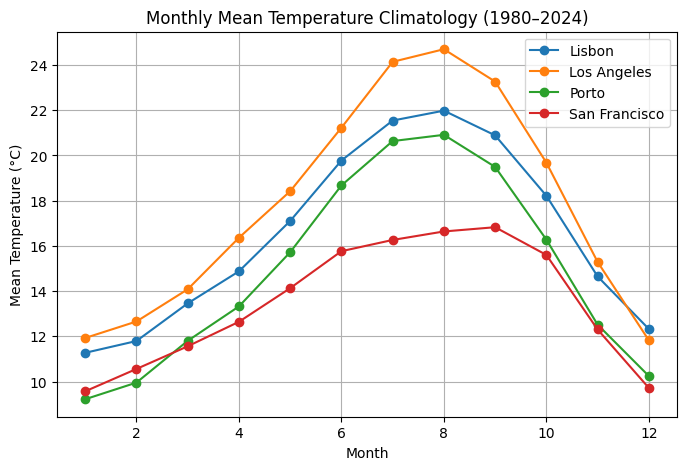

In [8]:
plt.figure(figsize=(8, 5))

for city in monthly["city_name"].unique():
    subset = monthly[monthly["city_name"] == city]
    plt.plot(subset["month"], subset["climatology_temp"], marker="o", label=city)

plt.xlabel("Month")
plt.ylabel("Mean Temperature (°C)")
plt.title("Monthly Mean Temperature Climatology (1980–2024)")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
tropical = q("""
SELECT
    city_name,
    year,
    SUM(CASE WHEN temperature_2m_min >= 20 THEN 1 ELSE 0 END) AS tropical_nights
FROM bronze_daily_weather
GROUP BY city_name, year
ORDER BY city_name, year
""")

tropical.head()

,city_name,year,tropical_nights
0,Lisbon,1980,10.0
1,Lisbon,1981,15.0
2,Lisbon,1982,9.0
3,Lisbon,1983,7.0
4,Lisbon,1984,7.0


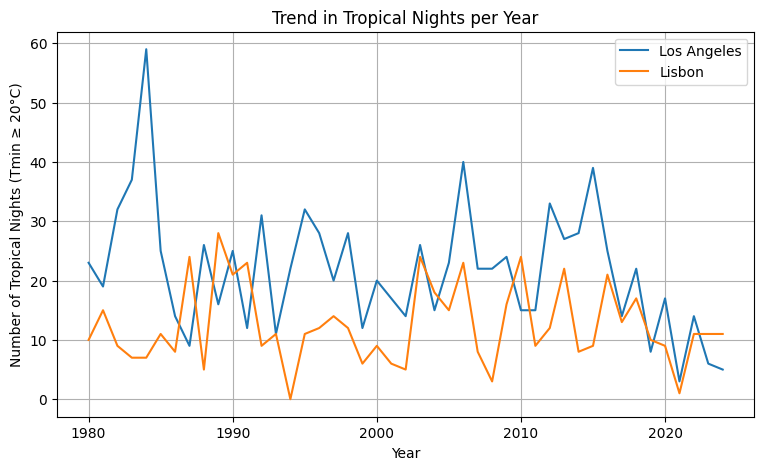

In [10]:
plt.figure(figsize=(9, 5))

for city in ["Los Angeles", "Lisbon"]:
    subset = tropical[tropical["city_name"] == city]
    plt.plot(subset["year"], subset["tropical_nights"], marker="", label=city)

plt.xlabel("Year")
plt.ylabel("Number of Tropical Nights (Tmin ≥ 20°C)")
plt.title("Trend in Tropical Nights per Year")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
heat = q("""
SELECT
    city_name,
    year,
    SUM(CASE WHEN temperature_2m_max >= 32 THEN 1 ELSE 0 END) AS hot_days
FROM bronze_daily_weather
GROUP BY city_name, year
ORDER BY city_name, year
""")

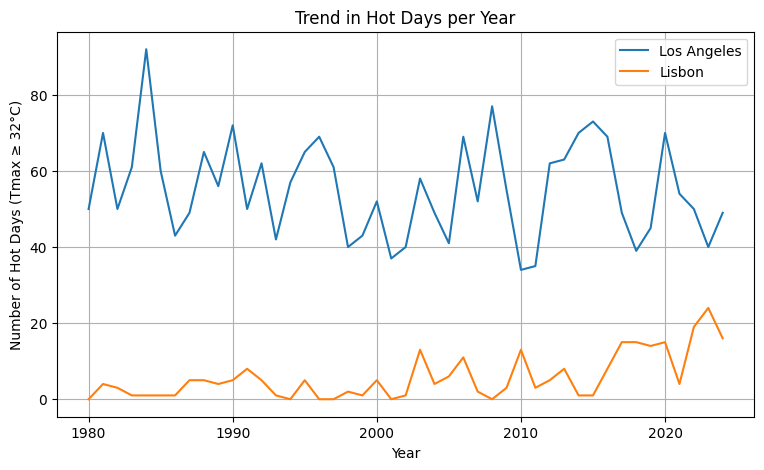

In [12]:
plt.figure(figsize=(9, 5))

for city in ["Los Angeles", "Lisbon"]:
    subset = heat[heat["city_name"] == city]
    plt.plot(subset["year"], subset["hot_days"], marker="", label=city)

plt.xlabel("Year")
plt.ylabel("Number of Hot Days (Tmax ≥ 32°C)")
plt.title("Trend in Hot Days per Year")
plt.legend()
plt.grid(True)
plt.show()

## Summary & Key Insights

- **Seasonality:** Los Angeles shows a milder annual cycle compared to Lisbon and Porto.
- **Heat days:** Lisbon experiences more frequent summer hot days than San Francisco and Porto, and is closer to Los Angeles in this respect.
- **Tropical nights:** There is a visible upward trend in tropical nights in Lisbon and Los Angeles after ~2000, suggesting warmer nights over time.
- **Wind & radiation:** [Fill in after you compute/plot these.]

This notebook demonstrates how the DuckDB + dbt pipeline supports downstream exploratory analysis and visualization in Python.